In [31]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs

In [ ]:
import os
import zipfile
import random
import os
#           os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import wget

In [32]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

# wget.download("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
#               "cats-and-dogs.zip")
#
# local_zip = 'cats-and-dogs.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('tmp')
# zip_ref.close()


In [33]:
print(len(os.listdir('tmp/PetImages/Cat/')))
print(len(os.listdir('tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [34]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11650457650101385486,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3127299278
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7617598327626051195
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"]

In [35]:
try:
    os.mkdir('tmp/cats-v-dogs')
    os.mkdir('tmp/cats-v-dogs/training')
    os.mkdir('tmp/cats-v-dogs/testing')
    os.mkdir('tmp/cats-v-dogs/training/cats')
    os.mkdir('tmp/cats-v-dogs/training/dogs')
    os.mkdir('tmp/cats-v-dogs/testing/cats')
    os.mkdir('tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [36]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [37]:
print(len(os.listdir('tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

12500
12500
10432
10403


In [38]:
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [39]:

TRAINING_DIR = "tmp/cats-v-dogs/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
train_dataset=tf.data.Dataset.from_generator(lambda:train_generator,
                                             output_types=(tf.float32, tf.float32),
                                             output_shapes=([None, 150, 150, 3],[None,])).prefetch(tf.data.experimental.AUTOTUNE)

VALIDATION_DIR = "tmp/cats-v-dogs/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))
valid_dataset=tf.data.Dataset.from_generator(lambda:validation_generator,
                                             output_types=(tf.float32, tf.float32),
                                             output_shapes=([None, 150, 150, 3],[None,])).prefetch(tf.data.experimental.AUTOTUNE)

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 24998 images belonging to 2 classes.
Found 20833 images belonging to 2 classes.


In [40]:
# Note that this may take some time.

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#
#
# # Disable all GPUS
# tf.config.set_visible_devices([], 'GPU')
# visible_devices = tf.config.get_visible_devices()
# for device in visible_devices:
#     assert device.device_type != 'GPU'


print('||||||||||||||||||||||||||||',device_lib.list_local_devices())

with mirrored_strategy.scope():
    history = model.fit(train_dataset,
                                  epochs=15,
                                  verbose=1,
                                  validation_data=valid_dataset,
                                  steps_per_epoch=(11250*2)/100,
                                  validation_steps=(1250*2)/100)

|||||||||||||||||||||||||||| [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5022470386519972676
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3127299278
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12894114302271004581
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]
Epoch 1/15
225/225 [==============================] - 210s 916ms/step - loss: 1.1655 - accuracy: 0.5450 - val_loss: 0.6388 - val_accuracy: 0.6448

C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
C:\Users\Sneha\anaconda3\lib\site-packages\PIL\TiffIma

<Figure size 432x288 with 0 Axes>

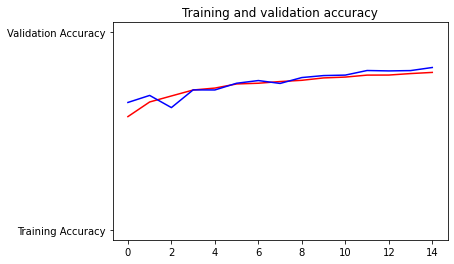

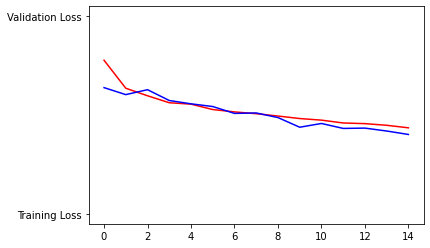

<Figure size 432x288 with 0 Axes>

In [43]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [46]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

ModuleNotFoundError: No module named 'google.colab'